In [1]:
from itertools import combinations, groupby

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial


from pymutspec.draw import plot_mutspec192, plot_mutspec12

In [2]:
tRNA_anticodon = pd.read_table('../data/external/reference_tRNA_anticodons-wStop.tsv')
tRNA_anticodon = tRNA_anticodon[tRNA_anticodon['AA.abr'] != 'Stop']
tRNA_anticodon = tRNA_anticodon.loc[:,['Codon.dna', 'AA.matchbool']]
tRNA_anticodon = tRNA_anticodon.rename(columns={'Codon.dna': 'Codon', 'AA.matchbool': 'Type'})
tRNA_anticodon.head()

,Codon,Type
0,TTT,near
1,TTC,*
2,TTA,*
3,TTG,near
4,CTT,near


In [3]:
observed = pd.read_table('../data/VertebratePolymorphisms.MutSpecDataWithNonSyn.txt', sep=' ')
observed.head()

,Species,Gene,AncestralSeqName,DescendantSeqName,Branch,CodonPosition,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C
1,Abbottina_obtusirostris,CytB,10,7,Internal,241,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248
2,Abbottina_obtusirostris,CytB,8,10,Internal,259,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248
3,Abbottina_obtusirostris,CytB,7,RN_2,External,135,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248
4,Abbottina_obtusirostris,CytB,9,RN_3,External,211,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248
5,Abbottina_obtusirostris,CytB,10,7,Internal,83,CTT,CAT,GCC,CTT,CAC,GCC,H,H,T_C,Syn,504,172,97,248


In [4]:
observed = observed.drop(['AncestralSeqName', 'DescendantSeqName', 'Branch', 'CodonPosition'], axis=1)
observed = observed[observed.Gene == 'CytB']
observed.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C
1,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248
2,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248
3,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248
4,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248
5,Abbottina_obtusirostris,CytB,CTT,CAT,GCC,CTT,CAC,GCC,H,H,T_C,Syn,504,172,97,248


In [5]:
obs_anticodon = observed.merge(tRNA_anticodon, left_on='AncestorCodon', right_on='Codon', how='left').drop('Codon', axis=1).rename(columns={'Type':'AncestorAnti'})
obs_anticodon = obs_anticodon.merge(tRNA_anticodon, left_on='DescendantCodon', right_on='Codon', how='left').drop('Codon', axis=1).rename(columns={'Type':'DescendantAnti'})
obs_anticodon.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C,AncestorAnti,DescendantAnti
0,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248,*,near
1,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248,near,near
2,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248,near,*
3,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248,*,*
4,Abbottina_obtusirostris,CytB,CTT,CAT,GCC,CTT,CAC,GCC,H,H,T_C,Syn,504,172,97,248,near,*


In [6]:
def define_type_anti(ancestral, descendant):
    if ancestral == '*' and descendant == '*':
        return ('WCF-WCF')
    elif ancestral == '*' and descendant == 'near':
        return ('WCF-Wooble')
    elif ancestral == 'near' and descendant == 'near':
        return ('Wooble-Wooble')
    elif ancestral == 'near' and descendant == '*':
        return ('Wooble-WCF')
    
def get_sub_pos(ancestral, descendant):
    '''Get position of substitution between Ancestor and Descendant codons.
    Args:
        seq1: Ancestral codon
        seq2: Descendant codon
    Returns:
        Number of position 
    '''
    for nuc_num in range(len(ancestral)):
        if ancestral[nuc_num] != descendant[nuc_num]:
            return nuc_num


def get_mutated_codon(codon, mutation, pos_of_mut):

    changed_nucleotide = mutation[4]
    if pos_of_mut == 0:
        return changed_nucleotide + codon[1] + codon[2]
    elif pos_of_mut == 1:
        return codon[0] + changed_nucleotide + codon[2]
    elif pos_of_mut == 2:
        return codon[0] + codon[1] + changed_nucleotide


def get_sub(ancestral, descendant):
    '''Get substitution between Ancestor and Descendant codons.
    Args:
        seq1: Ancestral codon
        seq2: Descendant codon
    Returns:
        Codon with substitution in format: A[A>T]C
    '''
    pos = get_sub_pos(ancestral, descendant)
    if pos == 0:
        return '[' + ancestral[0] + '>' + descendant[0] + ']' + ancestral[1] + ancestral[2]
    elif pos == 1:
        return ancestral[0] + '[' + ancestral[1] + '>' + descendant[1] + ']' + ancestral[2]
    elif pos == 2:
        return ancestral[0] +  ancestral[1] + '[' + ancestral[2] + '>'+ descendant[2] + ']'
    

def get_comp(row: pd.Series):
    ''' Get 3 and 5 components mutational spectrum from table
    Args:
        row - contains Ancestor and  Descendant codons
    Returns:
        out - pd.DataFrame with 3 and 5 component mutspec
    '''
    prev_anc_codon = row['PreviousAncCodon']
    anc_codon = row['AncestorCodon']
    next_anc_codon = row['NextAncCodon']
    des_codon = row['DescendantCodon']

    # Get position of substitution
    pos = get_sub_pos(anc_codon, des_codon)

    # Add subs 
    codon_with_sub = get_sub(anc_codon, des_codon)

    # Extract
    complete = list(prev_anc_codon + codon_with_sub + next_anc_codon)
    pos_in_complete = 3 + pos
    mut3 = complete[pos_in_complete - 1:pos_in_complete + 6]
    mut5 = complete[pos_in_complete - 2:pos_in_complete + 7]

    # Check if component is full (without - and ?)
    if '-' not in mut3 and '-' not in mut5 and '?' not in mut3 and '?' not in mut5:
        out = pd.DataFrame({'Species': row['Species'], 'Gene': row['Gene'],
                            'MutType': [row['TypeOfSubs']], '3Pos': row['3Pos'], 
                            'Mut3': ''.join(mut3), 'Mut5': ''.join(mut5), 'Pos': pos + 1, 'TypeOfAnti': row['TypeOfAnti']})
        return out
    

In [7]:
obs_anticodon['TypeOfAnti'] = obs_anticodon.apply(lambda x : define_type_anti(x.AncestorAnti, x.DescendantAnti), axis=1)
obs_anticodon = obs_anticodon.drop(['AncestorAnti', 'DescendantAnti'], axis=1)
obs_anticodon['TypeOfSubs'] = obs_anticodon['MutType'].apply(lambda x: 0 if x == 'NSyn' else(1 if x == 'Syn'  else 2))
obs_anticodon['3Pos'] = obs_anticodon.apply(lambda x: 1 if get_sub_pos(x.AncestorCodon, x.DescendantCodon) == 2 else 0, axis=1) 
obs_anticodon.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C,TypeOfAnti,TypeOfSubs,3Pos
0,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248,WCF-Wooble,2,1
1,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248,Wooble-Wooble,2,1
2,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248,Wooble-WCF,1,1
3,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248,WCF-WCF,1,0
4,Abbottina_obtusirostris,CytB,CTT,CAT,GCC,CTT,CAC,GCC,H,H,T_C,Syn,504,172,97,248,Wooble-WCF,1,1


In [8]:
final_obs = pd.concat(obs_anticodon.apply(lambda x: get_comp(x), axis=1).values)
final_obs.head()

,Species,Gene,MutType,3Pos,Mut3,Mut5,Pos,TypeOfAnti
0,Abbottina_obtusirostris,CytB,2,1,C[A>G]C,TC[A>G]CT,3,WCF-Wooble
0,Abbottina_obtusirostris,CytB,2,1,C[T>C]A,GC[T>C]AA,3,Wooble-Wooble
0,Abbottina_obtusirostris,CytB,1,1,G[G>A]G,TG[G>A]GG,3,Wooble-WCF
0,Abbottina_obtusirostris,CytB,1,0,C[T>C]T,GC[T>C]TA,1,WCF-WCF
0,Abbottina_obtusirostris,CytB,1,1,A[T>C]G,CA[T>C]GC,3,Wooble-WCF


# Expected mutations df

In [9]:
expected = pd.read_csv('../data/exp_mut_spec.csv', sep='\t')
expected = expected[expected.Gene == 'CYTB']
expected.head()

,Species,Gene,Mut3,MutType,Pos,3Pos,Codon
0,Rhinopithecus_bieti,CYTB,A[T>A]G,0,1,0,ATG
1,Rhinopithecus_bieti,CYTB,A[T>G]G,-1,1,0,ATG
2,Rhinopithecus_bieti,CYTB,A[T>C]G,0,1,0,ATG
3,Rhinopithecus_bieti,CYTB,T[G>A]A,1,2,1,ATG
4,Rhinopithecus_bieti,CYTB,T[G>T]A,0,2,1,ATG


In [10]:
expected['TransformedCodon'] = expected.apply(lambda x: get_mutated_codon(x.Codon, x.Mut3, x.Pos), axis=1)

In [11]:
exp_anticodon = expected.merge(tRNA_anticodon, left_on='Codon', right_on='Codon', how='left').drop('Codon', axis=1).rename(columns={'Type':'AncestorAnti'})
exp_anticodon = exp_anticodon.merge(tRNA_anticodon, left_on='TransformedCodon', right_on='Codon', how='left').drop(['TransformedCodon', 'Codon'], axis=1).rename(columns={'Type':'DescendantAnti'})
exp_anticodon['TypeOfAnti'] = exp_anticodon.apply(lambda x : define_type_anti(x.AncestorAnti, x.DescendantAnti), axis=1)
exp_anticodon.head()

,Species,Gene,Mut3,MutType,Pos,3Pos,AncestorAnti,DescendantAnti,TypeOfAnti
0,Rhinopithecus_bieti,CYTB,A[T>A]G,0,1,0,*,near,WCF-Wooble
1,Rhinopithecus_bieti,CYTB,A[T>G]G,-1,1,0,*,NaN,None
2,Rhinopithecus_bieti,CYTB,A[T>C]G,0,1,0,*,near,WCF-Wooble
3,Rhinopithecus_bieti,CYTB,T[G>A]A,1,2,1,*,near,WCF-Wooble
4,Rhinopithecus_bieti,CYTB,T[G>T]A,0,2,1,*,near,WCF-Wooble


In [12]:
final_exp = exp_anticodon.drop(['AncestorAnti', 'DescendantAnti'], axis=1)
final_exp.head()

,Species,Gene,Mut3,MutType,Pos,3Pos,TypeOfAnti
0,Rhinopithecus_bieti,CYTB,A[T>A]G,0,1,0,WCF-Wooble
1,Rhinopithecus_bieti,CYTB,A[T>G]G,-1,1,0,None
2,Rhinopithecus_bieti,CYTB,A[T>C]G,0,1,0,WCF-Wooble
3,Rhinopithecus_bieti,CYTB,T[G>A]A,1,2,1,WCF-Wooble
4,Rhinopithecus_bieti,CYTB,T[G>T]A,0,2,1,WCF-Wooble


### Save only Synonymous mutations

In [13]:
final_obs = final_obs[final_obs.MutType > 0] 
final_exp = final_exp[final_exp.MutType > 0]


In [14]:
sps_exp = final_exp['Species']
sps_obs = final_obs['Species']
print(len(sps_exp.unique()), len(sps_obs.unique()), sep=', ')


1312, 1562


In [15]:
final_obs = final_obs.loc[final_obs['Species'].isin(sps_exp.unique())]
sps_obs = final_obs['Species']
final_exp = final_exp.loc[final_exp['Species'].isin(sps_obs.unique())]

### Check that number of species in both df are the same

In [16]:
sps_exp = final_exp['Species']
sps_obs = final_obs['Species']
print(len(sps_exp.unique()), len(sps_obs.unique()), sep=', ')

1024, 1024


In [39]:
final_obs[final_obs.TypeOfAnti == 'WCF-WCF'].head()

,Species,Gene,MutType,3Pos,Mut3,Mut5,Pos,TypeOfAnti
0,Abbottina_obtusirostris,CytB,1,0,C[T>C]T,GC[T>C]TA,1,WCF-WCF
0,Abbottina_rivularis,CytB,1,0,C[C>T]T,CC[C>T]TA,1,WCF-WCF
0,Abbottina_rivularis,CytB,1,0,C[C>T]T,AC[C>T]TA,1,WCF-WCF
0,Abbottina_rivularis,CytB,1,0,A[C>T]T,TA[C>T]TA,1,WCF-WCF
0,Abbottina_rivularis,CytB,1,0,C[C>T]T,TC[C>T]TA,1,WCF-WCF


In [41]:
final_exp.Mut3.str.slice(2,5)

3          G>A
12         C>A
13         C>T
14         C>G
21         T>A
          ... 
4487388    T>A
4487389    T>G
4487390    T>C
4487398    A>G
4487407    A>G
Name: Mut3, Length: 836583, dtype: object

In [45]:
for cond_anti in list(final_obs.TypeOfAnti.unique()):
    exp_check = final_exp[final_exp.TypeOfAnti == cond_anti]
    obs_check = final_obs[final_obs.TypeOfAnti == cond_anti]

    print(f'Anticodon condition - {cond_anti} and expected df presented by 192 comp is {len(exp_check.Mut3.unique())} ; 12 comp is {len(exp_check.Mut3.str.slice(2, 5).unique())},'
          f'observed df presented by {len(obs_check.Mut3.unique())} ; 12 comp is {len(obs_check.Mut3.str.slice(2, 5).unique())}')

Anticodon condition - WCF-Wooble and expected df presented by 192 comp is 56 ; 12 comp is 5,observed df presented by 56 ; 12 comp is 5
Anticodon condition - Wooble-Wooble and expected df presented by 192 comp is 74 ; 12 comp is 6,observed df presented by 107 ; 12 comp is 12
Anticodon condition - Wooble-WCF and expected df presented by 192 comp is 56 ; 12 comp is 5,observed df presented by 56 ; 12 comp is 5
Anticodon condition - WCF-WCF and expected df presented by 192 comp is 8 ; 12 comp is 2,observed df presented by 80 ; 12 comp is 12


### Make function to calculate mutdpec for both types of the Anticodon combinations

In [17]:
### Additional function to translate triplets
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [18]:
def calculate_mutspec(observed, expected, type_of_anti_mut):

# Filter by anticodon relationships
    if type_of_anti_mut != 'all':
        observed = observed[observed.TypeOfAnti == type_of_anti_mut]
        expected = expected[expected.TypeOfAnti == type_of_anti_mut]

# Count codon freq for observed df
    count_obs_df = observed.groupby(['Species', 'Gene']).Mut3.value_counts()
    count_obs_df.name = 'CountMut3'
    count_obs_df = count_obs_df.reset_index()
    oberved_cnt = count_obs_df.pivot(index=['Species', 'Gene'], columns='Mut3', values='CountMut3').fillna(0)
    oberved_cnt['ExpectedObserved'] = 'Observed'

# Count codon freq for expected df
    count_exp_df = expected.groupby(['Species', 'Gene']).Mut3.value_counts()
    count_exp_df.name = 'CountMut3'
    count_exp_df = count_exp_df.reset_index()
    expected_cnt = count_exp_df.pivot(index=['Species', 'Gene'], columns='Mut3', values='CountMut3').fillna(0)
    expected_cnt['ExpectedObserved'] = 'Expected'

# Merge observed and expected 
    final_df = pd.concat([expected_cnt, oberved_cnt])
    final_df = final_df.sort_values(['Species'])
    final_df.insert(0, 'ExpectedObserved', final_df.pop('ExpectedObserved'))
    final_df = final_df.fillna(0)
    final_df = final_df.reset_index()

# Add 0 to not presented mutations for species

    possible_sbs192 = [
        "A[A>C]A", "A[A>C]C", "A[A>C]G", "A[A>C]T", "C[A>C]A", "C[A>C]C", "C[A>C]G", "C[A>C]T", 
        "G[A>C]A", "G[A>C]C", "G[A>C]G", "G[A>C]T", "T[A>C]A", "T[A>C]C", "T[A>C]G", "T[A>C]T", 
        "A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
        "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T", 
        "A[A>T]A", "A[A>T]C", "A[A>T]G", "A[A>T]T", "C[A>T]A", "C[A>T]C", "C[A>T]G", "C[A>T]T", 
        "G[A>T]A", "G[A>T]C", "G[A>T]G", "G[A>T]T", "T[A>T]A", "T[A>T]C", "T[A>T]G", "T[A>T]T", 
        "A[C>A]A", "A[C>A]C", "A[C>A]G", "A[C>A]T", "C[C>A]A", "C[C>A]C", "C[C>A]G", "C[C>A]T", 
        "G[C>A]A", "G[C>A]C", "G[C>A]G", "G[C>A]T", "T[C>A]A", "T[C>A]C", "T[C>A]G", "T[C>A]T", 
        "A[C>G]A", "A[C>G]C", "A[C>G]G", "A[C>G]T", "C[C>G]A", "C[C>G]C", "C[C>G]G", "C[C>G]T", 
        "G[C>G]A", "G[C>G]C", "G[C>G]G", "G[C>G]T", "T[C>G]A", "T[C>G]C", "T[C>G]G", "T[C>G]T", 
        "A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
        "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T", 
        "A[G>A]A", "A[G>A]C", "A[G>A]G", "A[G>A]T", "C[G>A]A", "C[G>A]C", "C[G>A]G", "C[G>A]T", 
        "G[G>A]A", "G[G>A]C", "G[G>A]G", "G[G>A]T", "T[G>A]A", "T[G>A]C", "T[G>A]G", "T[G>A]T", 
        "A[G>C]A", "A[G>C]C", "A[G>C]G", "A[G>C]T", "C[G>C]A", "C[G>C]C", "C[G>C]G", "C[G>C]T", 
        "G[G>C]A", "G[G>C]C", "G[G>C]G", "G[G>C]T", "T[G>C]A", "T[G>C]C", "T[G>C]G", "T[G>C]T", 
        "A[G>T]A", "A[G>T]C", "A[G>T]G", "A[G>T]T", "C[G>T]A", "C[G>T]C", "C[G>T]G", "C[G>T]T", 
        "G[G>T]A", "G[G>T]C", "G[G>T]G", "G[G>T]T", "T[G>T]A", "T[G>T]C", "T[G>T]G", "T[G>T]T", 
        "A[T>A]A", "A[T>A]C", "A[T>A]G", "A[T>A]T", "C[T>A]A", "C[T>A]C", "C[T>A]G", "C[T>A]T", 
        "G[T>A]A", "G[T>A]C", "G[T>A]G", "G[T>A]T", "T[T>A]A", "T[T>A]C", "T[T>A]G", "T[T>A]T", 
        "A[T>C]A", "A[T>C]C", "A[T>C]G", "A[T>C]T", "C[T>C]A", "C[T>C]C", "C[T>C]G", "C[T>C]T", 
        "G[T>C]A", "G[T>C]C", "G[T>C]G", "G[T>C]T", "T[T>C]A", "T[T>C]C", "T[T>C]G", "T[T>C]T", 
        "A[T>G]A", "A[T>G]C", "A[T>G]G", "A[T>G]T", "C[T>G]A", "C[T>G]C", "C[T>G]G", "C[T>G]T", 
        "G[T>G]A", "G[T>G]C", "G[T>G]G", "G[T>G]T", "T[T>G]A", "T[T>G]C", "T[T>G]G", "T[T>G]T", 
    ]

    for sbs in possible_sbs192:
        if sbs not in final_df.columns:
            final_df[sbs] = 0
    

    _counted_codons = final_df.melt(["Species", "ExpectedObserved"], final_df.columns[2:], var_name="Mut")
    mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
    
    mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
    mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
    rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})

    mutspecs = pd.merge(mutations, rawsum_df, on="Species")
    mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
    
    mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
    mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
    mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)

    
    return mutspecs
    

### Count mutations with context for both df

In [25]:
WCF_WCF_mutspec = calculate_mutspec(final_obs, final_exp, type_of_anti_mut='WCF-WCF')

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_718/1989590895.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[sbs] = 0
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_718/1989590895.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[sbs] = 0
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_718/1989590895.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [27]:
WCF_WCF_mutspec[(WCF_WCF_mutspec.Observed != 0) & (WCF_WCF_mutspec.Expected == 0)]

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
308,Abbottina_rivularis,T[G>A]C,0.0,1.0,0.0,3.305556,0.0,G>A,TGC
576,Acanthogobius_hasta,T[T>G]T,0.0,NaN,0.0,0.000000,NaN,T>G,TTT
577,Acanthogobius_hasta,G[T>G]T,0.0,NaN,0.0,0.000000,NaN,T>G,GTT
578,Acanthogobius_hasta,C[T>G]T,0.0,NaN,0.0,0.000000,NaN,T>G,CTT
579,Acanthogobius_hasta,A[T>G]T,0.0,NaN,0.0,0.000000,NaN,T>G,ATT
...,...,...,...,...,...,...,...,...,...
196412,Zosterops_erythropleurus,T[A>C]A,0.0,NaN,0.0,0.000000,NaN,A>C,TAA
196413,Zosterops_erythropleurus,G[A>C]A,0.0,NaN,0.0,0.000000,NaN,A>C,GAA
196414,Zosterops_erythropleurus,C[A>C]A,0.0,NaN,0.0,0.000000,NaN,A>C,CAA
196415,Zosterops_erythropleurus,A[A>C]A,0.0,NaN,0.0,0.000000,NaN,A>C,AAA


In [136]:
WCF_WCF_mutspec.sort_values(by='MutSpec', ascending=False)

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
47961,Elassoma_zonatum,G[T>A]A,7.0,1.0,0.142857,0.142857,1.0,T>A,GTA
12633,Apodemus_draco,G[T>A]A,5.0,1.0,0.200000,0.200000,1.0,T>A,GTA
125721,Ovis_aries,G[T>A]A,4.0,1.0,0.250000,0.250000,1.0,T>A,GTA
31637,Chlorocebus_pygerythrus,G[T>C]A,11.0,1.0,0.090909,0.090909,1.0,T>C,GTA
118997,Nomascus_siki,G[T>C]A,10.0,1.0,0.100000,0.100000,1.0,T>C,GTA
...,...,...,...,...,...,...,...,...,...
196603,Zosterops_japonicus,A[A>G]A,0.0,0.0,0.000000,0.000000,NaN,A>G,AAA
196604,Zosterops_japonicus,T[A>C]A,0.0,0.0,0.000000,0.000000,NaN,A>C,TAA
196605,Zosterops_japonicus,G[A>C]A,0.0,0.0,0.000000,0.000000,NaN,A>C,GAA
196606,Zosterops_japonicus,C[A>C]A,0.0,0.0,0.000000,0.000000,NaN,A>C,CAA


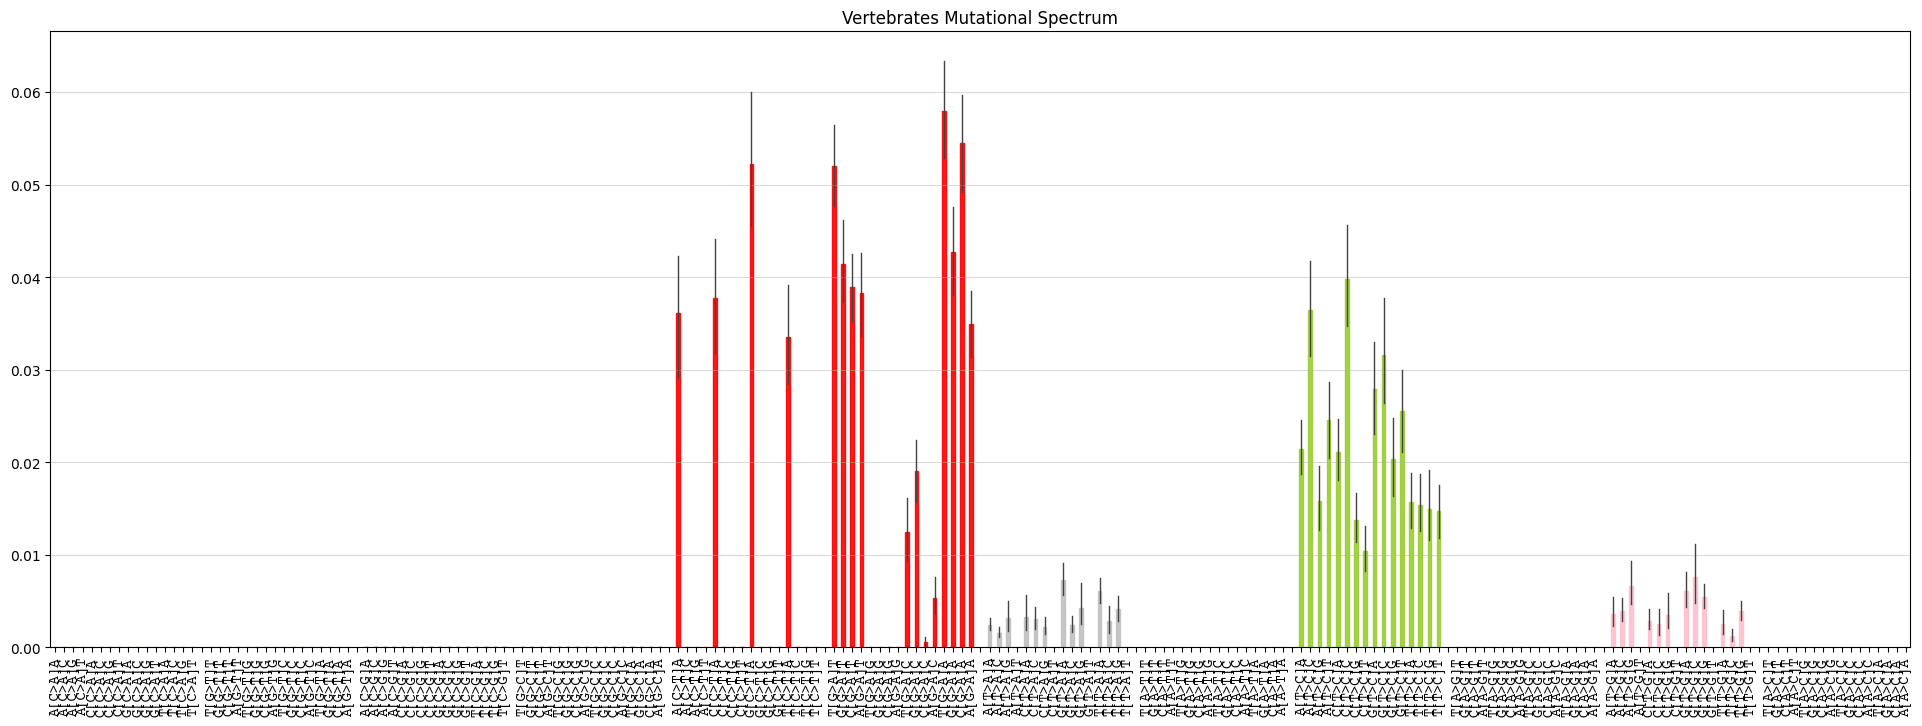

In [24]:
plot_mutspec192(WCF_WCF_mutspec, title='Vertebrates Mutational Spectrum',
                fontname='Courier', fontsize=10)